Analysis

Model to predict score for a player on a course given player statistics
For each course, for each year, gather player stats per round (+ course stats), and come up with predictive model for round score on course. 
-- or --
For each year, gather player stats per round. Then, predict course score from player stats (simpler)
Additionally, come up with model to predict round stats from player season (and/or career?) stats.

Scrape data!

Get scores of desired tournament
Get player stats for each player in tournament
Use player stats to predict score

https://www.pgatour.com/stats/stat.103.html player.json to find stats per player

In [1]:
import sys
#!conda install --yes --prefix {sys.prefix} selenium
from selenium import webdriver
import pandas as pd
import requests
import glob
import os

In [2]:
## Helper functions
def create_dir(path):
    try:
        os.makedirs(path)
    except FileExistsError:
        print()
        
def get_html(link):
    print("Fetching html at address:", link)
    response = urllib.request.urlopen(link)
    return response.read().decode('utf-8')
    
def save_html(link, outpath, cache=True):
    if os.path.isfile(outpath) and cache:
        print("Cached file found for", outpath)
        return
    
    html = get_html(link)
    with open(outpath,"w+") as output:
      output.write(html) 

def to_csv(html_path, outpath):
    create_dir(outpath)
    
    files = glob.glob(html_path+'/*.html')
    for f in files:
        with open(f) as html:
            df = pd.read_html(html)[1]
            path = f.split('/')
            csv_subdir = path[1]
            csv_fname = path[len(path)-1].split('.')[0]
            df.to_csv("{outpath}/{file}.csv".format(file=csv_fname, outpath=outpath))

In [3]:
## Set up directory structure for data
create_dir('html/masters')
create_dir('csv/masters')

In [5]:
## Collect and save all data in html format
import urllib.request
def get_tournament_data():
    url_template = "https://www.pgatour.com/tournaments/masters-tournament/past-results/jcr:content/mainParsys/pastresults.selectedYear.{year}.html"
    for year in range(1940,2019):
        response = urllib.request.urlopen(url_template.format(year=year))
        html = response.read().decode('utf-8')
        with open("html/masters/{year}.html".format(year=year),"w+") as output:
          output.write(html)

In [320]:
## Convert and save all html table data in csv format
import glob
headers = ["Player", "Position", 'R1', "R2", "R3", "R4", "Total", "Money", "Points"]

def tournament_to_csv(html_path):
    files = glob.glob(html_path+'/*.html')
    for f in files:
        with open(f) as html:
            df = pd.read_html(html)[0]
            df = df.iloc[:, :-2]
            df.columns = headers
            
            path = f.split('/')
            csv_subdir = path[1]
            csv_fname = path[len(path)-1].split('.')[0]
            df.to_csv('csv/{subdir}/{file}.csv'.format(file=csv_fname, subdir=csv_subdir))
     
tournament_to_csv('html/masters')

In [6]:
## Grab all stats per player for each year
# <a href="/stats/stat.02674.html">SG: Tee-to-Green</a>
import urllib.request
import re
from bs4 import BeautifulSoup

base_url = "https://www.pgatour.com/"

def get_stat_categories():
    url = base_url + "stats.html"
    r  = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    div = soup.find_all('div', {"class":"page-container"})[0]
    raw = div.select("a[href*=/stats/categories]")
    return list(map(lambda tag: base_url + tag['href'], raw))

def get_stats_for_category(link):
    r  = requests.get(link)
    soup = BeautifulSoup(r.text, 'html.parser')
    div = soup.find_all('div', {"class":"page-container"})[0]
    raw = div.select("a[href*=/stats/stat.]")
    return list(map(lambda tag: base_url + tag['href'], raw))

def load_stat_years(link):
    stat_page = get_html(link)    
    soup = BeautifulSoup(stat_page, 'html.parser')
    years = [option['value'] for option in soup.find('select', id='yearSelector').findAll('option')]
    
    comp = link.split('/')
    stat = comp[len(comp)-1].split('.')[1]
    return (stat, years)

def load_stats_for_year(year, _url, outdir, cache=True):
    comps = _url.split('/')
    
    fname = comps[-1]
    fname_comps = fname.split('.')
    fname_comps.insert(2, year)
    
    comps.pop(len(comps)-1)
    comps.insert(len(comps), '.'.join(fname_comps))
    url = '/'.join(comps)
    save_html(url, outdir + "{year}.html".format(year=year), cache=cache)
    
def load_stat(url, cache=True):
    stat, years = load_stat_years(url)
    outdir = "stats/raw/html/{stat}/".format(stat=stat)
    create_dir(outdir)
    for year in years:
        load_stats_for_year(year, url, outdir, cache=cache)
        
def load_all_stats(cache=True):
    category_links = get_stat_categories()
    visited = set()
    for link in category_links:
        stat_links = set(get_stats_for_category(link))
        for l in stat_links:
            load_stat(l)
        visited.update(stat_links)

In [7]:
stats_by_name = {
    # OFF THE TEE
    "SG_OTT": ("02567", "AVERAGE"),
    "SG_TTG": ("02674", "AVERAGE"),
    "PCT_YDG_TO_TEE": ("02341", "AVG (%)"),
    "AVG_DIST_TEE": ("101", "AVG."),
    "DRV_ACC": ("102", "%"),
    "LEFT_TEND": ("02422", "%"),
    "RIGHT_TEND": ("02423", "%"),
    "PCT_GOOD_DRIVE": ("02438", "%"),
    "CARRY_EFF": ("02410", "AVG."),
    "DIST_EFF": ("02411", "AVG."),
    
    # APPROACH THE GREEN
    "SG_APTG": ("02568", "AVERAGE"),
    "GIR_PCT": ("103","%"),
    "GFG_HIT_PCT": ("486", "%"),
    
    # AROUND THE GREEN
    "SG_ARTG": ("02569", "AVERAGE"),
    "SAND_SAVE_PCT": ("111", "%"),
    "SCRMBL": ("130", "%"),
    "SCRMBL_SAND": ("362", "%"),
    "SCRMBL_ROUGH": ("363", "%"),
    "SCRMBL_FRNG": ("364", "%"),
    "PROX_TO_HOL": ("374", "AVG DTP"),
    
    # PUTTING
    "SG_PUTT": ("02564", "AVERAGE")
}

In [81]:
def scores_for_year(tournament,year,by="round"):
    df_rounds = pd.read_csv('csv/{tourney}/{year}.csv'.format(year=year, tourney=tournament))
    if by == "round":
        df_rounds = df_rounds.melt(id_vars=["Player"], value_vars=["R1","R2", "R3", "R4"])
        df_rounds.drop(["variable"], axis=1,inplace=True)
        df_rounds.rename(columns={"Player": "PLAYER NAME", "value": "SCORE"}, inplace=True)
    else: 
        df_rounds = df_rounds.fillna(value={"R3":80, "R4": 80})
        df_rounds["Total"] = df_rounds["R1"] + df_rounds["R2"] + df_rounds["R3"] + df_rounds["R4"]
        df_rounds = df_rounds[["Player", "Total"]]
        df_rounds.rename(columns={"Player": "PLAYER NAME", "Total": "SCORE"}, inplace=True)
    df_rounds.dropna(inplace=True)
    return df_rounds

def classifications_for_year(tournament,year):
    df = pd.read_csv('csv/{tourney}/{year}.csv'.format(year=year, tourney=tournament))
    df["SCORE"] = df["R3"] > 0
    df = df[["Player", "SCORE"]]
    df.rename(columns={"Player": "PLAYER NAME"}, inplace=True)
    df.dropna(inplace=True)
    return df

In [9]:
def stats_for_year(year, cache=True):
    stats=stats_by_name.keys()
    df_stats = pd.DataFrame()

    for s in stats:
        id = stats_by_name[s][0]
        col = stats_by_name[s][1]
        outpath = "stats/raw/csv/{stat_id}/".format(stat_id=id)
        
        if not cache:
            html_path = "stats/raw/html/{stat_id}/".format(stat_id=id)
            load_stat("https://www.pgatour.com//stats/stat.{id}.html".format(id=id), cache=True)
            to_csv(html_path, outpath)
    
        df = pd.read_csv('{outpath}/{year}.csv'.format(outpath=outpath, year=year))
        df = df[["PLAYER NAME", col]]
        df.rename(columns={col: s}, inplace=True)
        if df_stats.empty:
            df_stats = df
        else:
            df_stats = df_stats.merge(df, on="PLAYER NAME")
            
    return df_stats

In [76]:
def masters_years_played():
    df = pd.DataFrame()
    for y in range(1970,2019):
        df_rounds = scores_for_year('masters',y, by="tourney")
        df_rounds["YEAR"] = y
        df = pd.concat([df,df_rounds])
    return df

def masters_data_set(by="round", target="score"):
    yp = masters_years_played()
    
    df = pd.DataFrame()
    for y in range(2008,2018):
        # player season stats
        df_stats = stats_for_year(y)
        
        # concat years played in masters
        by_year = yp[yp["YEAR"] < y+1]
        by_year = by_year.groupby("PLAYER NAME").size().reset_index(name='RD_PLAYED')
        by_year["YEAR"] = y+1
        df_stats = df_stats.merge(by_year, on="PLAYER NAME", how="inner")
        if ( target == "score"):
            df_rounds = scores_for_year('masters',y+1, by=by)
        else:
            df_rounds = classifications_for_year('masters', y+1)
        _df = df_rounds.merge(df_stats, on="PLAYER NAME", how="inner")
        df = pd.concat([df,_df])
    return df

In [68]:
x=masters_data_set(by="tournament")

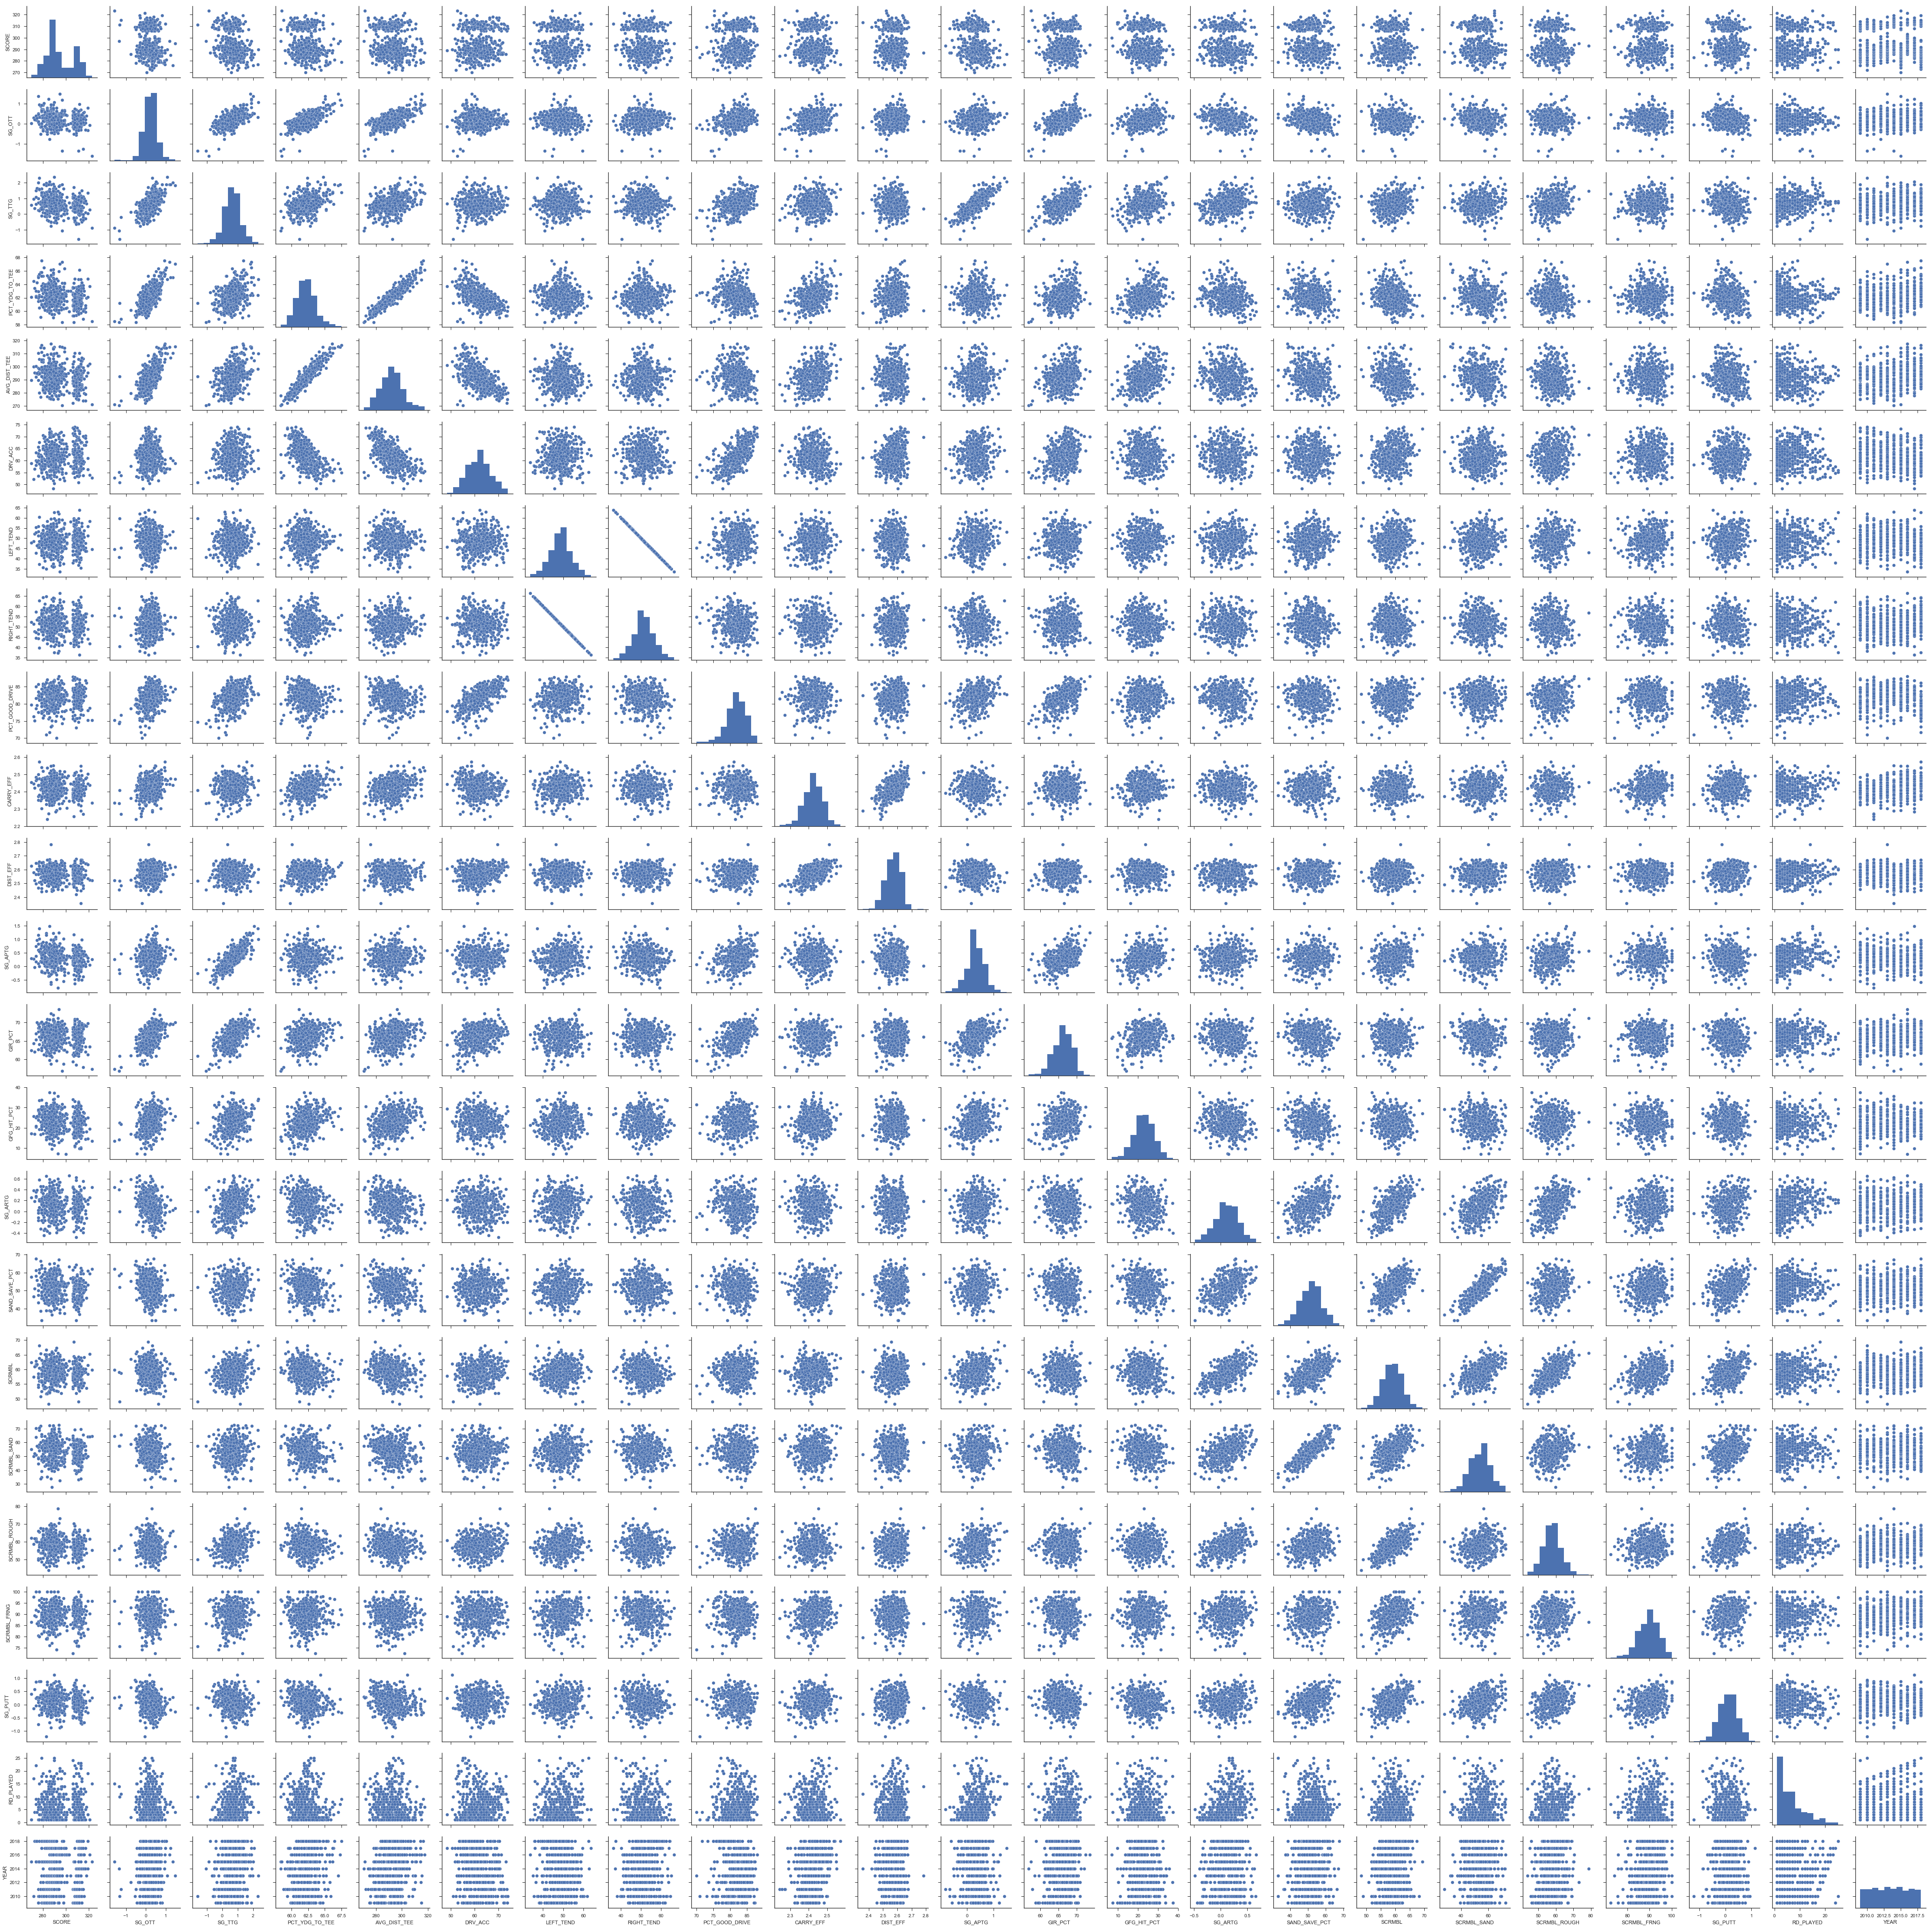

In [69]:
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(x)
plt.show()

In [11]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [43]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler

def lin_reg_model(_X, y):
    print("-- Linear regression model --")
    
    scaler = MinMaxScaler()
    X = scaler.fit_transform(_X)
    gsc = GridSearchCV(
        estimator=Ridge(),
        param_grid={
            'alpha': (.01,.1,1,10,100)
        },
        cv=5, scoring='r2', verbose=0,n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    print("Best alpha: ",best_params["alpha"])
    print("Score:", grid_result.best_score_)
    print("Score2:", grid_result.best_estimator_.score(X,y))
    
    return grid_result.best_estimator_

In [13]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
#from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score

def show_target_distribution(X,y):
    f, (ax0, ax1) = plt.subplots(1, 2)

    ax0.hist(y, bins=100)
    ax0.set_xlim([250, 350])
    ax0.set_ylabel('Probability')
    ax0.set_xlabel('Target')
    ax0.set_title("Target distribution")

#    ax1.hist(y_trans, bins=100, **density_param)
#    ax1.set_ylabel('Probability')
#    ax1.set_xlabel('Target')
#    ax1.set_title('Transformed target distribution')

    f.suptitle("Synthetic data", y=0.035)
    f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [14]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

def _rfr_model(_X,y):
    print("-- Random forest model --")
    
    scaler = MinMaxScaler()
    X = scaler.fit_transform(_X)
    forest = RandomForestRegressor(max_depth=8, random_state=0,
                                    n_estimators=1000)
    forest.fit(X, y)
    print("Score: ", forest.score(X,y))

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    %matplotlib inline
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    return forest

In [42]:
from sklearn.model_selection import cross_val_predict, GridSearchCV

def show_feature_importances(X,forest):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    %matplotlib inline
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
def rfr_model(X, y):
    print("-- Random forest model --")
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(random_state=0,n_estimators=1000),
        param_grid={
            'max_depth': (2,4,8,16)
        },
        cv=5, scoring='r2', verbose=0,n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    print("Max depth: ",best_params["max_depth"])
    print("Score:", grid_result.best_score_)
    print("Score2:", grid_result.best_estimator_.score(X,y))
    
    show_feature_importances(X,grid_result.best_estimator_)
    
    return grid_result.best_estimator_
#    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
    #scores = cross_val_predict(grid_result.best_estimator_, X, y, cv=10)
    #return scores

#scores = rfr_model(X,y)


In [54]:
from sklearn.svm import SVR
import numpy as np
def svr_model(X,y):
    print("-- SVR model --")
    gsc = GridSearchCV(
        estimator=SVR(),
        param_grid={
            'C': (10,100,1000),
            'epsilon': (.001,.01,.1,1,10)
        },
        cv=5, scoring='r2', verbose=0,n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    print("C: ",best_params["C"])
    print("Score:", grid_result.best_score_)
    print("Score2:", grid_result.best_estimator_.score(X,y))
        
    return grid_result.best_estimator_
    #clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
    #clf.fit(X, y) 


In [107]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
def simulate_picks(model, tournament_data):
    print("\n\nSimulate picks...\n\n")
    
    for y in range(tournament_data["YEAR"].min(),tournament_data["YEAR"].max()+1):
        if y == 2016: 
            continue
            
        df = tournament_data[tournament_data["YEAR"] == y]
        X = df.drop(["PLAYER NAME", "SCORE", "PROX_TO_HOL", "YEAR", "RD_PLAYED"],axis=1)
        predictions = model.predict(X)
#        print("TEST SCORE:",model.score(X,df["SCORE"]))
        
        n = 5
        predicted =  pd.concat([df["PLAYER NAME"], pd.Series(predictions)],axis=1).sort_values(0)
        actual  = df[["PLAYER NAME", "SCORE"]]
        charts = pd.read_csv('stats/raw/csv/127/{year}.csv'.format(year=y))
        
        pt = predicted.head(n)
        pt = actual.loc[actual['PLAYER NAME'].isin(pt['PLAYER NAME'])]
        
        ct = charts.head(n)
        ct = actual.loc[actual['PLAYER NAME'].isin(ct['PLAYER NAME'])]
        
        at = actual.head(n)
        
        pt_sum = pt["SCORE"].head(3).sum()
        at_sum = at['SCORE'].head(3).sum()
        charts_sum = ct["SCORE"].head(3).sum()
        print(str(y) + ": Actual - ", at_sum, "Predicted - ", pt_sum, "Charts -", charts_sum, "DIFF - ", abs(at_sum - pt_sum), "CHARTS - ", abs(at_sum - charts_sum))
        #if y == 2015:
            #display_side_by_side(predicted, actual, charts)


In [393]:
from sklearn.cluster import KMeans
import numpy as np

X = pd.DataFrame()
for y in range(2008,2018):
    stats = stats_for_year(y)
    stats.drop(["PLAYER NAME", "PROX_TO_HOL"], axis=1, inplace=True)
    X = pd.concat([X, stats], axis=0)

kmeans = KMeans(n_clusters=8, random_state=0).fit(X)
kmeans.labels_
#kmeans.predict(X)

kmeans.cluster_centers_
print()

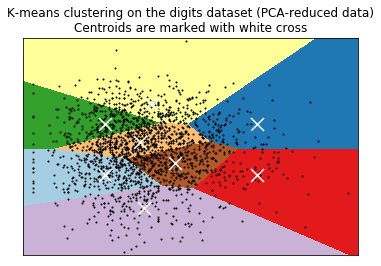

In [133]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init='k-means++', n_clusters=8, random_state=0)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


-- Linear regression model --
Best alpha:  10
Score: -0.04112570942289377
Score2: 0.11107183617413574


Simulate picks...


TEST SCORE: -16023.926311024934
2017: Actual -  840.0 Predicted -  866.0 Charts - 861.0 DIFF -  26.0 CHARTS -  21.0
TEST SCORE: -14870.991504609141
2018: Actual -  822.0 Predicted -  837.0 Charts - 837.0 DIFF -  15.0 CHARTS -  15.0
-- Random forest model --
Max depth:  4
Score: -0.04844700843474384
Score2: 0.39158481286274466
Feature ranking:
1. feature 1 (0.139918)
2. feature 12 (0.116473)
3. feature 19 (0.091937)
4. feature 14 (0.068345)
5. feature 2 (0.065490)
6. feature 7 (0.057859)
7. feature 3 (0.053428)
8. feature 15 (0.051990)
9. feature 10 (0.049429)
10. feature 0 (0.042294)
11. feature 4 (0.041897)
12. feature 17 (0.033442)
13. feature 11 (0.032291)
14. feature 9 (0.027758)
15. feature 18 (0.025003)
16. feature 16 (0.023140)
17. feature 5 (0.022621)
18. feature 6 (0.021982)
19. feature 8 (0.019224)
20. feature 13 (0.015479)


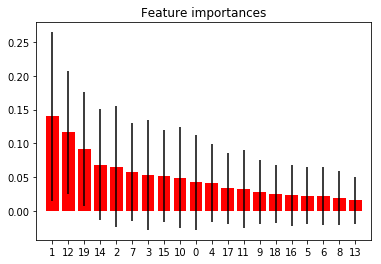



Simulate picks...


TEST SCORE: 0.15063419274668077
2017: Actual -  840.0 Predicted -  850.0 Charts - 861.0 DIFF -  10.0 CHARTS -  21.0
TEST SCORE: -0.039337556807270246
2018: Actual -  822.0 Predicted -  833.0 Charts - 837.0 DIFF -  11.0 CHARTS -  15.0
-- SVR model --
C:  100
Score: -0.10824679578818486
Score2: 0.9999999923812487


Simulate picks...


TEST SCORE: -0.019035119110822674
2017: Actual -  840.0 Predicted -  867.0 Charts - 861.0 DIFF -  27.0 CHARTS -  21.0
TEST SCORE: -0.1380090106511631
2018: Actual -  822.0 Predicted -  852.0 Charts - 837.0 DIFF -  30.0 CHARTS -  15.0


In [55]:
def analyze_masters():
    ## get data
    _df = masters_data_set(by="tourney")
    df = _df[_df["YEAR"] < 2017]
    test = _df[_df["YEAR"] >= 2017]
    X = df.drop(["PLAYER NAME","SCORE", "PROX_TO_HOL", "YEAR", "RD_PLAYED"],axis=1)
    y = df["SCORE"]
    #scores = rfr_model(X,y)
    
    ## visialize data
    show_target_distribution(X,y)
    
    ## models
    lr_model = lin_reg_model(X,y)
    simulate_picks(lr_model, test)
    
    _rf_model = rfr_model(X,y)
    simulate_picks(_rf_model, test)
    
    svr =svr_model(X,y)
    simulate_picks(svr, test)
    
for x in range(0,1):
    analyze_masters()

# graph season data with green to red points 

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def train_logistic_regression(X,y):
    print("\n\n-- Logistic regression model --\n\n")
    gsc = GridSearchCV(
        estimator=LogisticRegression(),
        param_grid={
            'C': (.01,.1,1,10,100),
        },
        cv=5, scoring='accuracy', verbose=0,n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    print("C: ",best_params["C"])
    print("Training Score:", grid_result.best_score_)
        
    return grid_result.best_estimator_
    
def train_svc(X,y):
    print("\n\n-- SVC model --\n\n")
    gsc = GridSearchCV(
        estimator=SVC(kernel='rbf'),
        param_grid={
            'C': (.01,.1,1,10,100),
        },
        cv=5, scoring='accuracy', verbose=0,n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    print("C: ",best_params["C"])
    print("Training Score:", grid_result.best_score_)
        
    return grid_result.best_estimator_

def train_random_forest_classifier(X,y):
    print("\n\n-- Random forest model --\n\n")
    gsc = GridSearchCV(
        estimator=RandomForestClassifier(n_estimators=1000),
        param_grid={
            'max_depth': (2,4,8,16),
        },
        cv=5, scoring='accuracy', verbose=0,n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    print("Max depth: ",best_params["max_depth"])
    print("Training Score:", grid_result.best_score_)
        
    return grid_result.best_estimator_

In [108]:
from sklearn.linear_model import LogisticRegression

def analyze_masters_classification():
    ## get data
    df = masters_data_set(by="tourney", target="classfication")
    scaler = MinMaxScaler()
    _X = df.drop(["PLAYER NAME","SCORE", "PROX_TO_HOL", "YEAR", "RD_PLAYED"],axis=1)
    X = scaler.fit_transform(_X)
    y = df["SCORE"]
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    
    ## models
    lr_model = train_logistic_regression(X_train,y_train)
    print("Test score: ",lr_model.score(X_test, y_test))
    simulate_picks(lr_model, df)
    
    svc_model = train_svc(X_train,y_train)
    print("Test score: ",svc_model.score(X_test, y_test))
    simulate_picks(svc_model, df)
    
    rf_model = train_random_forest_classifier(X_train, y_train)
    print("Test score: ",rf_model.score(X_test, y_test))    
    simulate_picks(rf_model, df)
    
for x in range(0,1):
    analyze_masters_classification()




-- Logistic regression model --


C:  100
Training Score: 0.7232876712328767
Test score:  0.6639344262295082


Simulate picks...


2009: Actual -  3 Predicted -  3 Charts - 2 DIFF -  0 CHARTS -  1
2010: Actual -  3 Predicted -  3 Charts - 3 DIFF -  0 CHARTS -  0
2011: Actual -  3 Predicted -  3 Charts - 3 DIFF -  0 CHARTS -  0
2012: Actual -  3 Predicted -  3 Charts - 2 DIFF -  0 CHARTS -  1
2013: Actual -  3 Predicted -  3 Charts - 3 DIFF -  0 CHARTS -  0
2014: Actual -  3 Predicted -  1 Charts - 2 DIFF -  2 CHARTS -  1
2015: Actual -  3 Predicted -  3 Charts - 3 DIFF -  0 CHARTS -  0
2017: Actual -  3 Predicted -  3 Charts - 3 DIFF -  0 CHARTS -  0
2018: Actual -  3 Predicted -  3 Charts - 3 DIFF -  0 CHARTS -  0


-- SVC model --


C:  0.01
Training Score: 0.7068493150684931
Test score:  0.6885245901639344


Simulate picks...


2009: Actual -  3 Predicted -  3 Charts - 2 DIFF -  0 CHARTS -  1
2010: Actual -  3 Predicted -  3 Charts - 3 DIFF -  0 CHARTS -  0
2011: Actual -  3 Predi

In [60]:
def am():
    ## get data
    df = masters_data_set(by="tourney")
    X_train, X_test, y_train, y_test = train_test_split(df.drop(["PLAYER NAME","SCORE", "PROX_TO_HOL", "YEAR", "RD_PLAYED"],axis=1),df["SCORE"])
    
    print("-- Random forest model --")
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(random_state=0,n_estimators=1000),
        param_grid={
            'max_depth': (2,4,8,16)
        },
        cv=5, scoring='r2', verbose=0,n_jobs=-1)
    
    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    
    print("Max depth: ",best_params["max_depth"])
    print("Train score: ", grid_result.best_estimator_.score(X_train,y_train))
    print("Test score: ",grid_result.best_estimator_.score(X_test,y_test))
    
for x in range(0,5):
    am()

# graph season data with green to red points 

-- Random forest model --
Max depth:  4
Train score:  0.40391608583712324
Test score:  0.06088602199083637
-- Random forest model --
Max depth:  8
Train score:  0.7907130262075737
Test score:  -0.010848181706860638
-- Random forest model --
Max depth:  8
Train score:  0.7595722752924996
Test score:  0.04070969727416118
-- Random forest model --
Max depth:  2
Train score:  0.18793622240002872
Test score:  0.03558035535736259
-- Random forest model --
Max depth:  4
Train score:  0.4288634316521993
Test score:  0.019209621052956538


In [103]:
def scatter_plot_data(_X, _y):

    scaler = MinMaxScaler()
    X = scaler.fit_transform(_X)
    reduced_data = PCA(n_components=2).fit_transform(X)
    
    yscaler = MinMaxScaler()
    y = pd.DataFrame( scaler.fit_transform([_y]) )
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y, cmap="GnRd", alpha=0.5)
    plt.show()

df = masters_data_set(by="tourney", target="classification")
X = df.drop(["PLAYER NAME","SCORE", "PROX_TO_HOL","YEAR"],axis=1)
y = df["SCORE"]

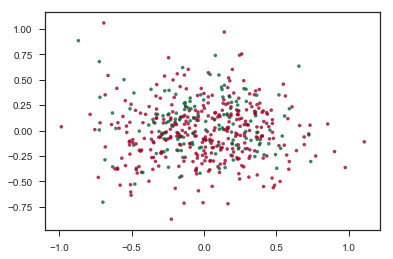

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fixing random state for reproducibility
#np.random.seed(19680801)


#N = 5
#x = np.random.rand(N)
#y = np.random.rand(N)
#colors = np.random.rand(N)
#print(x)
#print(y)
#print(colors)

#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

scaler = MinMaxScaler()
XX = scaler.fit_transform(X)
reduced_data = PCA(n_components=2).fit_transform(XX)

#print(y)
#print(yy[:,0])
#print(reduced_data[:,0])

plt.scatter(reduced_data[:,0], reduced_data[:,1], s=10, c=y, cmap="RdYlGn_r", alpha=.8)
#plt.show()

In [ ]:
# Other model ideas for features:
# past experience in the tournament (experience in general)
# clustering
# model individual players given course attributes
# model what it takes to win at a particular course (missing data)

In [349]:
df = pd.DataFrame()
for y in range(1970,2009):
    df_rounds = scores_for_year('masters',y, by="tourney")
    df_rounds["YEAR"] = y
    df = pd.concat([df,df_rounds])
df

PLAYER NAME  SCORE  YEAR
0          Billy Casper  279.0  1970
1          Gene Littler  279.0  1970
2           Gary Player  280.0  1970
3           Bert Yancey  281.0  1970
4           Tommy Aaron  283.0  1970
5             Dave Hill  283.0  1970
6         Dave Stockton  283.0  1970
7         Jack Nicklaus  284.0  1970
8           Frank Beard  285.0  1970
9              Bob Lunn  287.0  1970
10    Chi Chi Rodriguez  287.0  1970
11        Charles Coody  288.0  1970
12          Bert Greene  288.0  1970
13         Tony Jacklin  288.0  1970
14          Don January  288.0  1970
15         Takaaki Kono  288.0  1970
16          Bob Charles  289.0  1970
17        Howie Johnson  290.0  1970
18            Dick Lotz  290.0  1970
19        Orville Moody  290.0  1970
20        Miller Barber  291.0  1970
21         Terry Wilcox  291.0  1970
22          Deane Beman  292.0  1970
23         Julius Boros  292.0  1970
24           Bob Murphy  292.0  1970
25            Sam Snead  292.0  1970
26         Tom Weiskopf  292.0  1970
27          Charles Coe  292.0  1970
28        Yung-Yo Hsieh  293.0  1970
29           Jim Wright  293.0  1970
..                  ...    ...   ...
63           Ben Curtis  310.0  2008
64          Trip Kuehne  310.0  2008
65        Shaun Micheel  310.0  2008
66         John Rollins  310.0  2008
67       Steve Stricker  310.0  2008
68      Camilo Villegas  310.0  2008
69           Tom Watson  310.0  2008
70      Bernhard Langer  311.0  2008
71  Jose Maria Olazabal  311.0  2008
72          John Senden  311.0  2008
73        Vaughn Taylor  311.0  2008
74     Michael Thompson  311.0  2008
75         Woody Austin  312.0  2008
76            Tim Clark  312.0  2008
77         Ben Crenshaw  312.0  2008
78        Richard Green  312.0  2008
79      Shingo Katayama  312.0  2008
80         Peter Lonard  312.0  2008
81    Mark Calcavecchia  313.0  2008
82         Soren Hansen  313.0  2008
83          D.J. Trahan  313.0  2008
84       Scott Verplank  313.0  2008
85        Raymond Floyd  314.0  2008
86             WC Liang  314.0  2008
87        Anders Hansen  315.0  2008
88          Drew Weaver  316.0  2008
89         Steve Lowery  317.0  2008
90           Larry Mize  318.0  2008
91        Fuzzy Zoeller  320.0  2008
92          Gary Player  321.0  2008

[3274 rows x 3 columns]

In [352]:
df.groupby("PLAYER NAME").size().reset_index(name='COUNT')
df[df["PLAYER NAME"] == "Vijay Singh"].agg('count')

PLAYER NAME    15
SCORE          15
YEAR           15
dtype: int64

In [73]:
df = pd.read_csv('csv/{tourney}/{year}.csv'.format(year=2010, tourney='masters'))
df["TARGET"] = df["R3"] > 0
df

Unnamed: 0            Player Position  R1    R2    R3    R4  Total  \
0            0    Phil Mickelson        1  67  71.0  67.0  67.0    272   
1            1      Lee Westwood        2  67  69.0  68.0  71.0    275   
2            2       Anthony Kim        3  68  70.0  73.0  65.0    276   
3            3         K.J. Choi       T4  67  71.0  70.0  69.0    277   
4            4       Tiger Woods       T4  68  70.0  70.0  69.0    277   
5            5      Fred Couples        6  66  75.0  68.0  70.0    279   
6            6       Nick Watney        7  68  76.0  71.0  65.0    280   
7            7      Hunter Mahan       T8  71  71.0  68.0  71.0    281   
8            8         Y.E. Yang       T8  67  72.0  72.0  70.0    281   
9            9      Ricky Barnes      T10  68  70.0  72.0  73.0    283   
10          10       Ian Poulter      T10  68  68.0  74.0  73.0    283   
11          11    Miguel Jimenez      T12  72  75.0  72.0  66.0    285   
12          12       Jerry Kelly      T12  72  74.0  67.0  72.0    285   
13          13   Trevor Immelman      T14  69  73.0  72.0  72.0    286   
14          14      Steve Marino      T14  71  73.0  69.0  73.0    286   
15          15        Ryan Moore      T14  72  73.0  73.0  68.0    286   
16          16        David Toms      T14  69  75.0  71.0  71.0    286   
17          17     Angel Cabrera      T18  73  74.0  69.0  71.0    287   
18          18         Ernie Els      T18  71  73.0  75.0  68.0    287   
19          19        Adam Scott      T18  69  75.0  72.0  71.0    287   
20          20      Heath Slocum      T18  72  73.0  70.0  72.0    287   
21          21    Scott Verplank      T18  73  73.0  73.0  68.0    287   
22          22        Tom Watson      T18  67  74.0  73.0  73.0    287   
23          23         Ben Crane      T24  71  75.0  74.0  68.0    288   
24          24       Matt Kuchar      T24  70  73.0  74.0  71.0    288   
25          25         Bill Haas      T26  72  70.0  71.0  76.0    289   
26          26      Geoff Ogilvy      T26  74  72.0  69.0  74.0    289   
27          27       Kenny Perry      T26  72  71.0  72.0  74.0    289   
28          28        Yuta Ikeda       29  70  77.0  72.0  71.0    290   
29          29      Jason Dufner      T30  75  72.0  75.0  69.0    291   
..         ...               ...      ...  ..   ...   ...   ...    ...   
66          66          Kevin Na      CUT  74  76.0   NaN   NaN    150   
67          67     Alvaro Quiros      CUT  75  75.0   NaN   NaN    150   
68          68       David Duval      CUT  76  75.0   NaN   NaN    151   
69          69         Brian Gay      CUT  74  77.0   NaN   NaN    151   
70          70     Todd Hamilton      CUT  74  77.0   NaN   NaN    151   
71          71     Marc Leishman      CUT  72  79.0   NaN   NaN    151   
72          72      Rory McIlroy      CUT  74  77.0   NaN   NaN    151   
73          73  Edoardo Molinari      CUT  76  75.0   NaN   NaN    151   
74          74      John Rollins      CUT  75  76.0   NaN   NaN    151   
75          75     Oliver Wilson      CUT  78  73.0   NaN   NaN    151   
76          76      Stewart Cink      CUT  76  76.0   NaN   NaN    152   
77          77   Shingo Katayama      CUT  75  77.0   NaN   NaN    152   
78          78  Louis Oosthuizen      CUT  75  77.0   NaN   NaN    152   
79          79        Paul Casey      CUT  75  78.0   NaN   NaN    153   
80          80       Ross Fisher      CUT  77  76.0   NaN   NaN    153   
81          81    Rory Sabbatini      CUT  75  78.0   NaN   NaN    153   
82          82       Vijay Singh      CUT  76  78.0   NaN   NaN    154   
83          83        Chris Wood      CUT  78  76.0   NaN   NaN    154   
84          84     Byeong-Hun An      CUT  78  77.0   NaN   NaN    155   
85          85      Ben Crenshaw      CUT  77  78.0   NaN   NaN    155   
86          86     Chang-won Han      CUT  79  76.0   NaN   NaN    155   
87          87        Sandy Lyle      CUT  69  86.0   NaN   NaN    155   
88      